In [2]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [3]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [11]:
# Run a short test
bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 1 people in the queue


# First experiment: 100 trials

An arrival rate of 0.8 and a service rate of 1: There are 1 people in the queue.



In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
result = []
for i in range(1,101):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=i)
    result.append(bus_system.queue.people_in_queue)
results = np.hstack(result)

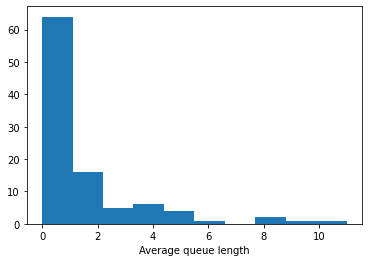

In [53]:
x = results
plt.figure()
plt.hist(x) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

In [50]:
m = np.mean(x)
t = sts.sem(x)

print('The sample mean is', m)
print('Standard error of the mean:', t)
print('95% confidence interval of population mean:', [m - 1.96*t, m + 1.96*t])

The sample mean is 1.54
Standard error of the mean: 0.21434419596395501
95% confidence interval of population mean: [1.1198853759106482, 1.9601146240893519]


# Second experiment: 1000 trials

In [47]:
result1 = []
for i in range(1,1001):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=i)
    result1.append(bus_system.queue.people_in_queue)
results1 = np.hstack(result1)

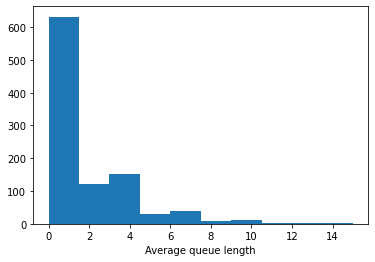

In [52]:
y = results1
plt.figure()
plt.hist(y) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

In [51]:
m1 = np.mean(y)
t1 = sts.sem(y)

print('The sample mean is', m1)
print('Standard error of the mean:', t1)
print('95% confidence interval of population mean:', [m1 - 1.96*t1, m1 + 1.96*t1])

The sample mean is 1.601
Standard error of the mean: 0.06857478765188779
95% confidence interval of population mean: [1.4665934162023, 1.7354065837977]


Compare the results from the two experiments. Comment on the following.
a. Whether and how the distribution (histogram) over queue length changed.
b. Whether and how the average queue length estimate changed.
c. Whether and how the confidence interval of the average queue length changed.

a. The shapes remain similar.

b. The average queue length estimate became higher and the standard error of the mean became lower.

c. The confidence interval became narrower in the 1000 trials.

# Error Plot

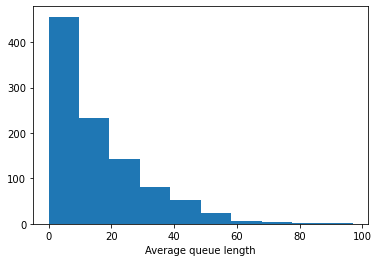

The sample mean is 15.642
Standard error of the mean: 0.4706796950956939
95% confidence interval of population mean: [14.71946779761244, 16.56453220238756]


In [54]:
# Arrival rate of 1 and service rate of 1 for 1000 trials
result2 = []
for i in range(1,1001):
    bus_system = run_simulation(arrival_rate=1, service_rate=1, run_until=i)
    result2.append(bus_system.queue.people_in_queue)
results2 = np.hstack(result2)

z = results2
plt.figure()
plt.hist(z) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

m2 = np.mean(z)
t2 = sts.sem(z)

print('The sample mean is', m2)
print('Standard error of the mean:', t2)
print('95% confidence interval of population mean:', [m2 - 1.96*t2, m2 + 1.96*t2])

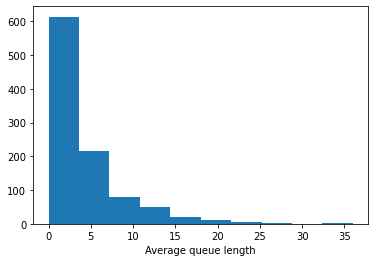

The sample mean is 3.879
Standard error of the mean: 0.14678523394710008
95% confidence interval of population mean: [3.591300941463684, 4.166699058536317]


In [55]:
# Arrival rate of 0.9 and service rate of 1 for 1000 trials

result3 = []
for i in range(1,1001):
    bus_system = run_simulation(arrival_rate=0.9, service_rate=1, run_until=i)
    result3.append(bus_system.queue.people_in_queue)
results3 = np.hstack(result3)

u = results3
plt.figure()
plt.hist(u) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

m3 = np.mean(u)
t3 = sts.sem(u)

print('The sample mean is', m3)
print('Standard error of the mean:', t3)
print('95% confidence interval of population mean:', [m3 - 1.96*t3, m3 + 1.96*t3])

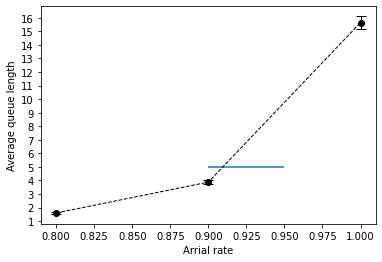

In [67]:
# Make the error plot of average queue length
x1 = [0.8, 0.9, 1] # the arrival rate
y1 = [1.601, 3.879, 15.642] # the average queue length
y1_error=[0.069, 0.147, 0.471] #value of the error

plt.figure()
plt.errorbar(x1,y1,y1_error, color='black', marker='o', capsize = 5, linestyle='--', linewidth=1) 
plt.yticks(np.arange(1,17))
plt.hlines(y = 5, xmin = 0.9, xmax = 0.95)
plt.xlabel('Arrial rate')
plt.ylabel('Average queue length')
plt.show()

Probably after arrival rate becomes 0.91, the average queue length becomes more than 5.

# Reflection

#EmpiricalAnalysis: The results obtained from running a simulation visualize with histograms and error plots, summarized with mean, standard error and confidence interval, and interpreted correctly with comparison between the 100 and 1000 trails. The simulation was running multiple times to derive some insights about how arrival rate relates to average queue length.

#professionalism, I have properly labeled the axes, chosen the appropriate types of graph to present my results. I also produced a well-organized Python notebook and following all presentation guidelines, including detailed in-line code comments for readers. Finally, the pre-class work is completed well before class and uploaded onto the right platform to present in class.